<a href="https://colab.research.google.com/github/lfzuloaga-dot/Algoritmo-Financiero-Simulaciones-Monte-Carlo/blob/main/Modelo_de_Aviones_Optimizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📊 ESTADÍSTICAS MEJORADAS POR MES
               mean      std      min       max  CV(%)   VaR_95%  \
Mes                                                                
Diciembre   84978.0  12865.0  44087.0  135980.0   15.1  106405.0   
Octubre     48393.0   7303.0  24176.0   73180.0   15.1   60428.0   
Marzo       42906.0   6329.0  13134.0   65727.0   14.8   53416.0   
Septiembre  42055.0   6323.0  17231.0   63626.0   15.0   52373.0   
Noviembre   40721.0   6143.0  19109.0   60926.0   15.1   50757.0   
Mayo        40492.0   6105.0  15702.0   64988.0   15.1   50374.0   
Julio       36977.0   5589.0  15720.0   57560.0   15.1   46007.0   
Febrero     36878.0   5601.0  16489.0   56923.0   15.2   46243.0   
Enero       35223.0   5297.0  14706.0   54588.0   15.0   43771.0   
Junio       34757.0   5187.0  15680.0   54647.0   14.9   43270.0   
Agosto      28989.0   4351.0  12557.0   44257.0   15.0   36107.0   
Abril       28699.0   4239.0   8855.0   42619.0   14.8   35774.0   

            Ex

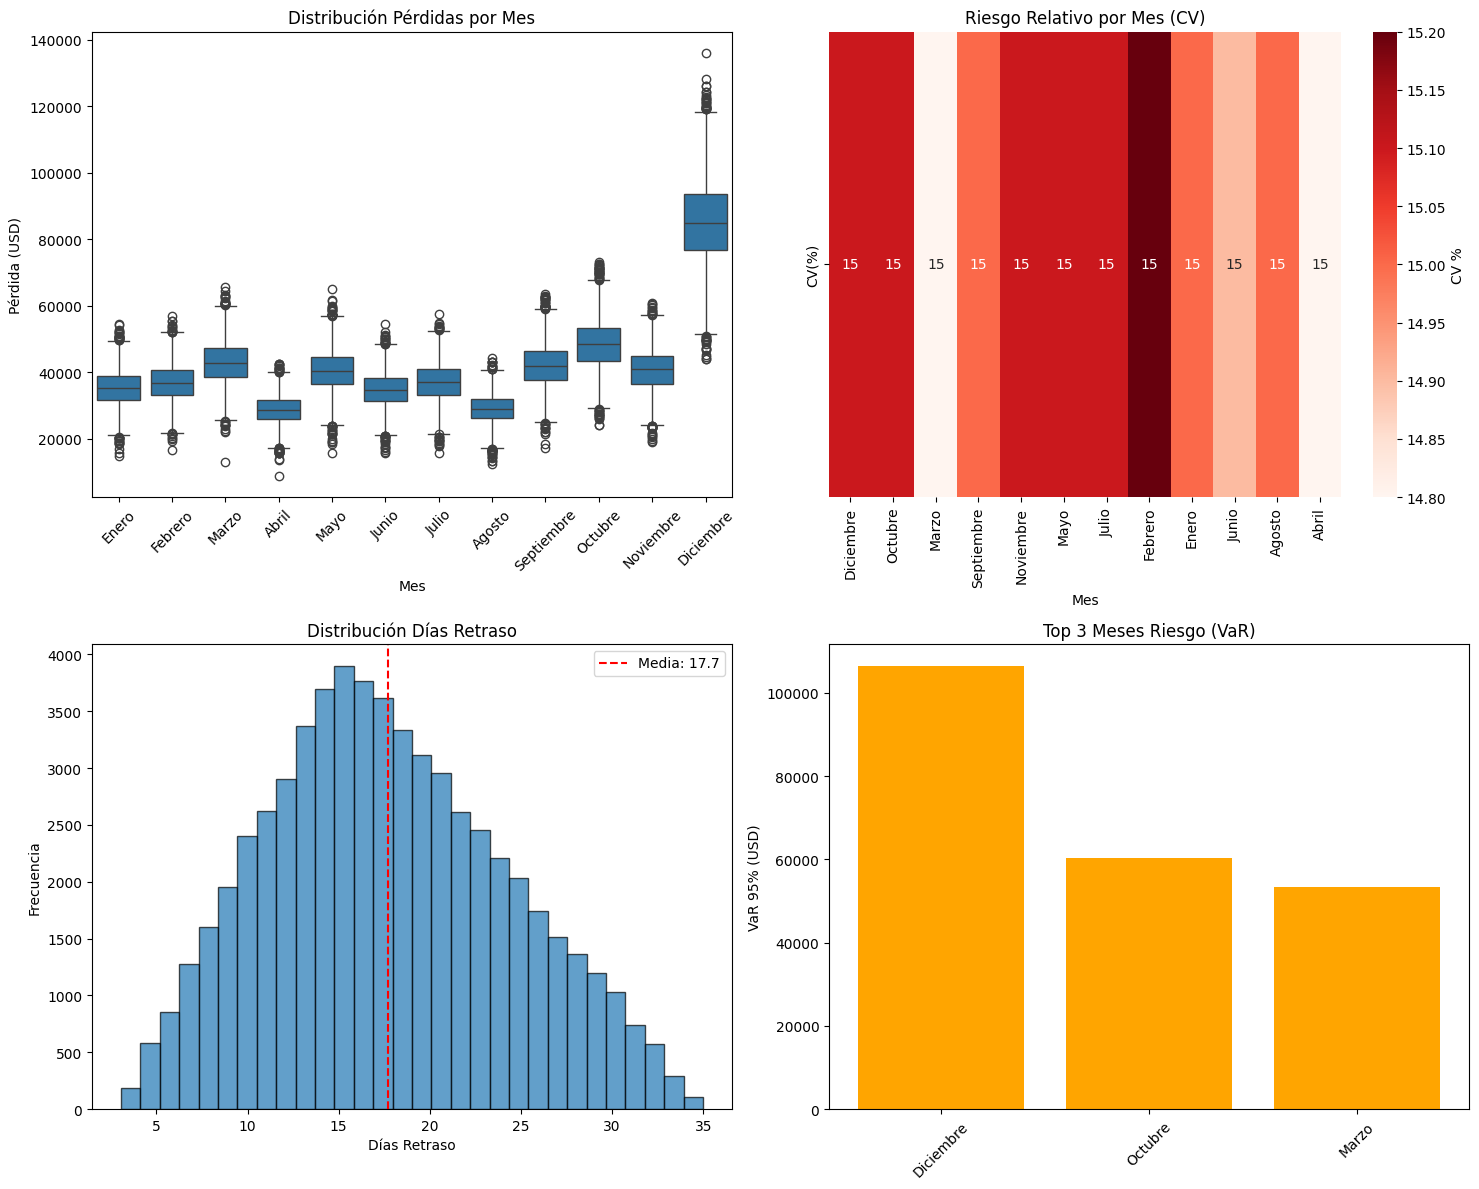


✅ MODELO CORREGIDO:
- Factor compounding correcto (multiplicación)
- Distribuciones triangulares realistas
- VaR 95% y Expected Shortfall
- 5000 iteraciones (vs 1000)
- Análisis riesgo mensual anual


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parámetros base mejorados
Cr = 20000  # Costo repuestos por avión
Cm = 800    # Costo mano de obra por avión
N = 2       # Aviones no registrados
inflacion_anual = 0.027
retorno_anual = 0.053

# Tasas diarias CORRECTAS (compounding diario)
rd = (1 + inflacion_anual)**(1/365) - 1
id = (1 + retorno_anual)**(1/365) - 1

# Índices estacionales (sin cambios)
iem_dict = {
    'Enero': 0.8406, 'Febrero': 0.8833, 'Marzo': 1.0252, 'Abril': 0.6868,
    'Mayo': 0.9702, 'Junio': 0.8310, 'Julio': 0.8901, 'Agosto': 0.6948,
    'Septiembre': 1.0085, 'Octubre': 1.1607, 'Noviembre': 0.9742, 'Diciembre': 2.0344
}

# Simulación Monte Carlo MEJORADA (5000 iteraciones)
n_simulaciones = 5000
resultados = []

for mes, iem_base in iem_dict.items():
    for _ in range(n_simulaciones):
        # Distribuciones más realistas
        dias = np.random.triangular(3, 15, 35)  # Triangular: más probable ~15 días
        iem = np.random.normal(iem_base, iem_base*0.15)  # ±15% variabilidad

        costo_base = Cr + Cm
        costo_inflado = costo_base * (1 + rd)**dias  # CORRECCIÓN: multiplicación
        costo_oportunidad = costo_inflado * id * dias  # Costo de oportunidad separado

        perdida = N * (costo_inflado + costo_oportunidad) * max(0, iem)
        resultados.append({
            'Mes': mes,
            'Dias': dias,
            'IEM': iem,
            'Costo_Inflado': costo_inflado,
            'Costo_Oportunidad': costo_oportunidad,
            'Perdida_Total': perdida
        })

df = pd.DataFrame(resultados)

# Métricas financieras clave (VaR, Expected Shortfall)
print("📊 ESTADÍSTICAS MEJORADAS POR MES")
print("="*60)

estadisticas = df.groupby('Mes')['Perdida_Total'].agg([
    'mean', 'std', 'min', 'max'
]).round(0)

estadisticas['CV(%)'] = (estadisticas['std'] / estadisticas['mean'] * 100).round(1)
estadisticas['VaR_95%'] = df.groupby('Mes')['Perdida_Total'].quantile(0.95).round(0)
estadisticas['Expected_Shortfall'] = df.groupby('Mes')['Perdida_Total'].apply(lambda x: x[x > x.quantile(0.95)].mean()).round(0)
estadisticas = estadisticas.sort_values('mean', ascending=False)

print(estadisticas)

# ANÁLISIS VaR ANUAL
var_anual_95 = df['Perdida_Total'].quantile(0.95)
print(f"\n💰 VaR 95% ANUAL: ${var_anual_95:,.0f}")
print(f"💰 Pérdida Esperada Mensual Promedio: ${df['Perdida_Total'].mean():,.0f}")

# Gráficos mejorados
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Boxplot pérdidas por mes
sns.boxplot(data=df, x='Mes', y='Perdida_Total', ax=axes[0,0])
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_title('Distribución Pérdidas por Mes')
axes[0,0].set_ylabel('Pérdida (USD)')

# 2. Heatmap CV por mes
sns.heatmap(estadisticas[['CV(%)']].T, annot=True, cmap='Reds', ax=axes[0,1], cbar_kws={'label': 'CV %'})
axes[0,1].set_title('Riesgo Relativo por Mes (CV)')

# 3. Distribución días
axes[1,0].hist(df['Dias'], bins=30, alpha=0.7, edgecolor='black')
axes[1,0].axvline(df['Dias'].mean(), color='red', linestyle='--', label=f'Media: {df.Dias.mean():.1f}')
axes[1,0].set_xlabel('Días Retraso')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].legend()
axes[1,0].set_title('Distribución Días Retraso')

# 4. TOP 3 meses riesgo (VaR 95%)
top_meses = estadisticas.nlargest(3, 'VaR_95%')
axes[1,1].bar(range(len(top_meses)), top_meses['VaR_95%'], color='orange')
axes[1,1].set_xticks(range(len(top_meses)))
axes[1,1].set_xticklabels(top_meses.index, rotation=45)
axes[1,1].set_ylabel('VaR 95% (USD)')
axes[1,1].set_title('Top 3 Meses Riesgo (VaR)')

plt.tight_layout()
plt.show()

print("\n✅ MODELO CORREGIDO:")
print("- Factor compounding correcto (multiplicación)")
print("- Distribuciones triangulares realistas")
print("- VaR 95% y Expected Shortfall")
print("- 5000 iteraciones (vs 1000)")
print("- Análisis riesgo mensual anual")